### Auto-encoders gebruiken om outliers te herkennen

In dit tech report zullen we een lineaire en niet-lineaire auto-encoder gebruiken om een dominant patroon in een dataset te leren zonder supervisie en om datapunten te vinden die dit patroon niet volgen (die we als outliers zullen beschouwen). 

Auto-encoders zijn een implementatie van een strategie waarbij gegevens worden geprojecteerd in een lagere-dimensionale ruimte en vervolgens weer worden gereconstrueerd naar de oorspronkelijke ruimte. Hierbij gaat informatie verloren, waardoor de reconstructie enigszins afwijkt van de oorspronkelijke gegevens. Vaak volgen datapunten in reële processen specifieke patronen waarbij niet alle combinaties van variabelen mogelijk zijn (in een koelkast is bijvoorbeeld de verdamper altijd koud als de condensor heet is). 

Deze vorm van correlatie maakt het mogelijk de datapunten te beschrijven met minder dimensies dan de oorspronkelijke set zonder veel informatie te verliezen, waardoor het proces van dimensiereductie en reconstructie vrij nauwkeurig verloopt. Voor datapunten die niet aan deze afhankelijkheid voldoen (een koelkast die defect is) zal het reconstructieproces echter zeer grote afwijkingen genereren omdat de veronderstelde relatie niet van toepassing is.

Daarom kunnen auto-encoders worden gebruikt als modellen voor anomaliedetectie, aangezien het reconstructieverlies (de door de hele cyclus gegenereerde fout) een indicatie is of het datapunt al dan niet de dominante trend in de dataset als geheel volgt. 

Wij zullen twee eenvoudige voorbeelddatasets in 2D gebruiken om het concept te illustreren: data_diagonal.csv (met een diagonaal lijnvormig patroon) en data_gate.csv (met een niet-lineair patroon in de vorm van een hoefijzer). In deze datasets worden de datapunten met waarde 'a' beschouwd als regelmatige punten en waarde 'b' als uitschieters (we zullen deze vertalen naar 0'en en 1'en). De modellen krijgen geen toegang tot deze eigenschappen, maar wij kunnen ze gebruiken om de resultaten later te evalueren. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,4)

<AxesSubplot:xlabel='x', ylabel='y'>

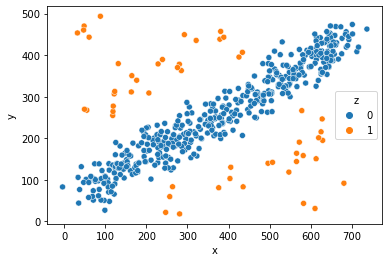

In [2]:
df = pd.read_csv('data_diagonal.csv').assign(z = lambda d: np.where(d.z == 'a',0,1))
X_train = np.array(df[['x', 'y']])
sns.scatterplot(data = df, x='x', y = 'y', hue = 'z')

## Principal component analysis

Principal component analysis is een techniek waarbij lineaire combinaties (componenten genoemd) van de oorspronkelijke variabelen worden gevonden die zoveel mogelijk van de variantie in de gegevens verklaren. De componenten met de laagste bijdrage aan de variantie worden verwijderd, waardoor enige informatie verloren gaat. De gegevens kunnen vervolgens worden gereconstrueerd door de lineaire berekening om te keren, waarna het verschil met de oorspronkelijke waardes wordt berekend. 

Wij demonstreren dit proces voor 2D-gegevens die worden geprojecteerd naar 1D en weer gereconstrueerd naar 2D, met als resultaat een rechte lijn. De kleur in de figuur geeft aan hoe groot de reconstructiefout (verlies) is (gegeven door de afstand van het datapunt tot de rechte lijn).

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
pca = PCA(n_components=1)

X_train_pca = pca.fit_transform(X_train)
X_projected = pca.inverse_transform(X_train_pca)

In [5]:
df['loss'] = np.sum((X_train - X_projected) ** 2, axis=1)

<AxesSubplot:>

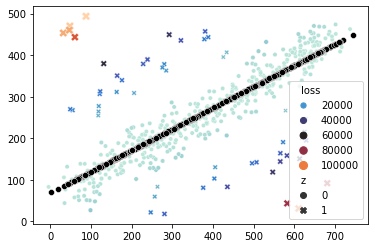

In [6]:
sns.scatterplot(x = X_train[:,0], y = X_train[:,1], hue = df['loss'], size = df['loss'], palette = "icefire", style = df.z)
sns.scatterplot(x = X_projected[:,0], y = X_projected[:,1], color = 'black')

We kunnen nu onderzoeken of deze reconstructiefout een goede maat is voor de vraag of een datapunt een outlier is of niet. Onderstaande figuur laat zien dat de fout veel groter is voor de datapunten die we als outliers (z=1) hadden bestempeld dan voor de gewone datapunten (z=0)! 

<AxesSubplot:xlabel='z', ylabel='loss'>

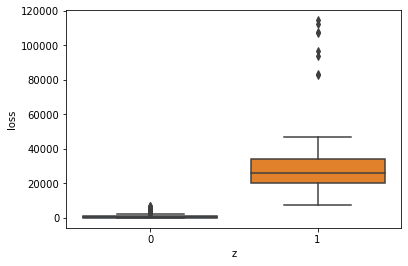

In [7]:
sns.boxplot(y = df.loss, x = df.z)

# Neurale netwerken

Principal component analysis is een lineaire methode, en kan dus geen non-lineaire verbanden volgen. Neurale netwerken bieden hier een uitkomst: we kunnen een architectuur ontwerpen met twee netwerken, de encoder en de decoder, met een bottleneck in het midden. De bottleneck is in ons voorbeeld een laag met maar één neuron wat het netwerk dwingt om de 2D datapunten (x- en y-coordinaat) in één getal samen te vatten. Vanuit dit ene getal worden vervolgens de x- en y- coordinaten gereconstrueerd net als in de PCA, maar omdat de encoder en decoder uit meerdere lagen neuronen met activatie functies bestaat kan deze handeling op een non-lineaire manier worden gedaan. 

Om dit concept te illustreren kijken we naar een tweede dataset, met een hoefijzer vorm en enkele datapunten die deze vorm niet volgen (onze outliers). We laten vervolgens eerst ons lineaire PCA model er op los en daarna een neuraal netwerk.

<AxesSubplot:xlabel='x', ylabel='y'>

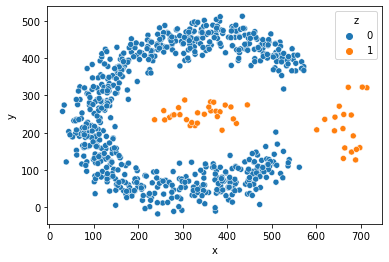

In [8]:
df2 = pd.read_csv('data_pacman.csv').assign(z = lambda d: np.where(d.z == 'a',0,1))
X_train2 = np.array(df2[['x', 'y']])
sns.scatterplot(data = df2, x='x', y = 'y', hue = 'z')

In [9]:
pca2 = PCA(n_components=1)

X_train_pca2 = pca2.fit_transform(X_train2)
X_projected2 = pca2.inverse_transform(X_train_pca2)

In [10]:
df2['loss'] = np.sum((X_train2 - X_projected2) ** 2, axis=1)

<AxesSubplot:>

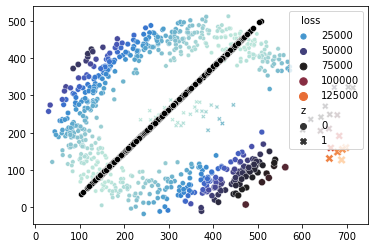

In [11]:
sns.scatterplot(x = X_train2[:,0], y = X_train2[:,1], hue = df2['loss'], size = df2['loss'], palette = "icefire", style = df2.z)
sns.scatterplot(x = X_projected2[:,0], y = X_projected2[:,1], color = 'black')

Het PCA model kan de kromme vorm helemaal niet vinden en voorspelt zowel voor outliers als voor reguliere datapunten soms een hele hoge error en soms een hele lage. Dit helpt dus niet bij het herkennen van outliers!

<AxesSubplot:xlabel='z', ylabel='loss'>

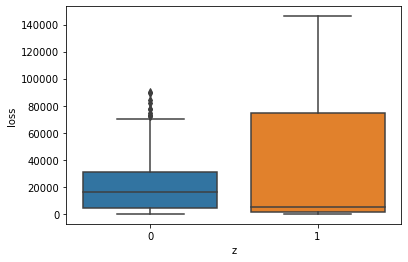

In [12]:
sns.boxplot(y = df2.loss, x = df2.z)

Voor het neurale netwerk maken we gebruik van een encoder/decoder van 2 lagen met ieder 4 neuronen en een tangens hyperbolicus als activatiefunctie. In deze lagen kunnen de x- en y-coordinaten (input en output layers zijn dus 2 neuronen) op een non-lineaire manier worden gerecombineerd. 
NB: hoe groter je de encoder en decoder maakt (meer lagen en/of meer neuronen per laag) hoe complexer het patroon dat gemodelleerd kan worden maar ook hoe groter het risico op overfitting!  

De bottleneck bestaat uit een laag van één neuron, het netwerk wordt dus gedongen om de positie van ieder datapunt op een 1D as te projecteren. De encoder en decoder hebben meestal dezelfde vorm omdat een datapunt projecteren op een lagere dimensionele ruimte en het reconstrueren van vergelijkbare complexiteit is. 

We schalen de data ook op naar een gestandaardiseerde schaal gecentreerd rond 0 omdat neurale netwerken dan het snelste getrained kunnen worden. Het netwerk wordt 400 epochs getrained (de dataset wordt 400 keer door het model heen gehaald waarbij telkens de gewichten worden bijgesteld om de reconstrueerde punten zo dicht mogelijk bij de oorspronkelijke te krijgen). 

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from keras_visualizer import visualizer

In [14]:
X_scale = StandardScaler().fit_transform(X_train2)

In [15]:
model = keras.Sequential([
    layers.Input(shape=(X_scale.shape[1],)),
    layers.Dense(4, activation='tanh', use_bias = True),
    layers.Dense(4, activation='tanh',use_bias = True),
    layers.Dense(1, activation='tanh',use_bias = True),
    layers.Dense(4, activation='tanh',use_bias = True),
    layers.Dense(4, activation='tanh',use_bias = True),
    layers.Dense(X_scale.shape[1])
])

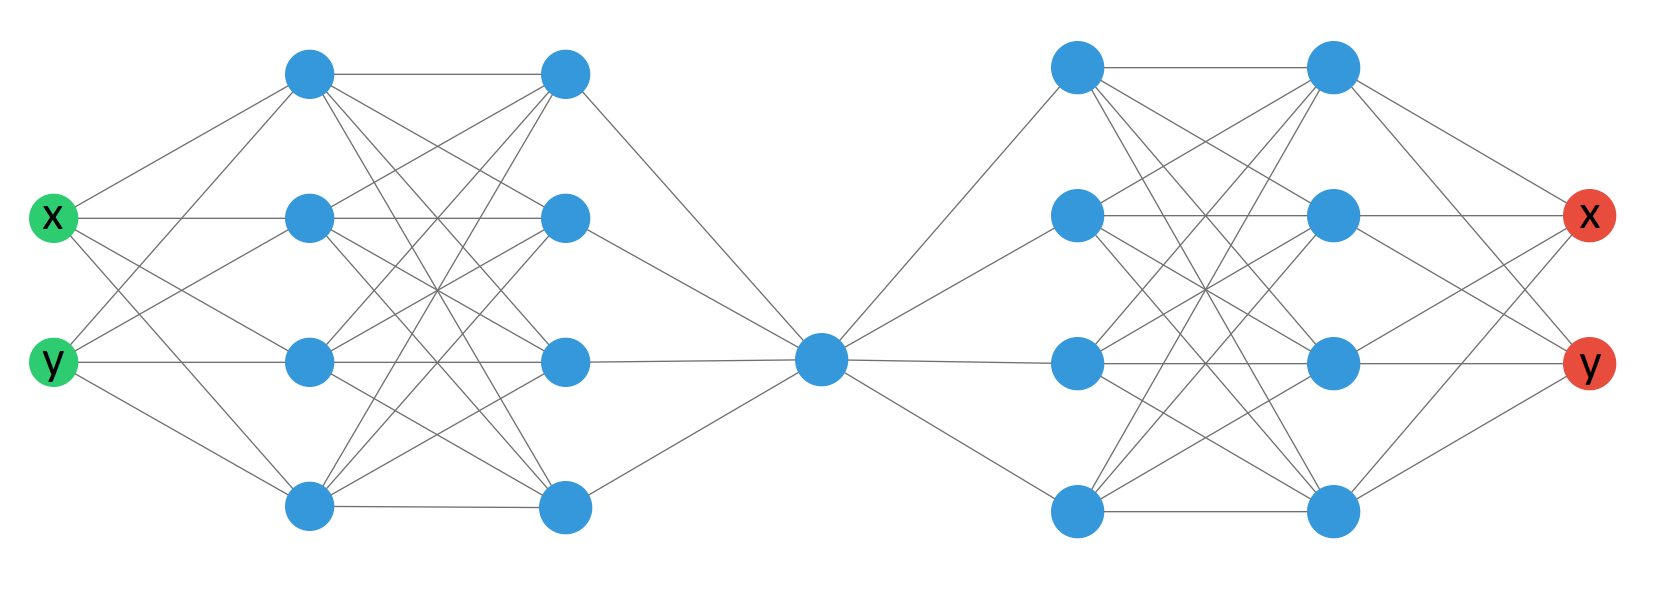

In [16]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

In [17]:
history = model.fit(
    X_scale,
    X_scale,
    epochs=400,
    batch_size=8,
    validation_split=0.2,
    verbose = 0
)

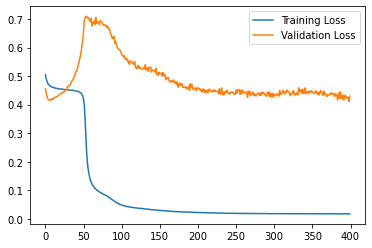

In [18]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

Bovenstaande grafiek laat zien dat het model steeds beter in staat is om de datapunten te volgen naar mate de data vaker door het model heen wordt gehaald. Na 400 epochs is er een stabiel niveau bereikt. 

Nu worden alle datapunten nog één keer door het model gehaald en berekenen we per punt de afwijking tussen de originele positie en de gereconstrueerde positie. Beide posities plotten we op een x-y vlak (alle gereconstrueerde punten - in het zwart - liggen op een lijn omdat ze berekend zijn vanuit één enkel getal).

In [19]:
X_scale_pred = model.predict(X_scale)
df2['loss_ae'] = np.sum((X_scale - X_scale_pred) ** 2, axis=1)

24/24 [==============================] - 0s 2ms/step


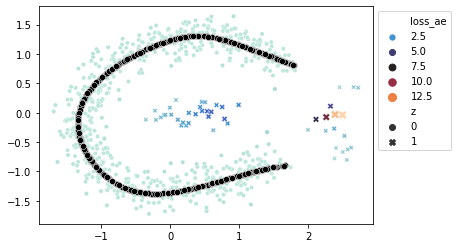

In [20]:
ax = sns.scatterplot(x = X_scale[:,0], y = X_scale[:,1], hue = df2['loss_ae'],size = df2['loss_ae'], palette = "icefire", style = df2.z )
sns.scatterplot(x = X_scale_pred[:,0], y = X_scale_pred[:,1], color = 'black')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


De kromme lijn kan het dominante patroon in de data goed volgen! Ook zien we dat de error veel hoger is voor de punten die we als anomalie hadden gelabeld dus deze methode is geschikt om anomalies te kunnen herkennen!

<AxesSubplot:xlabel='z', ylabel='loss_ae'>

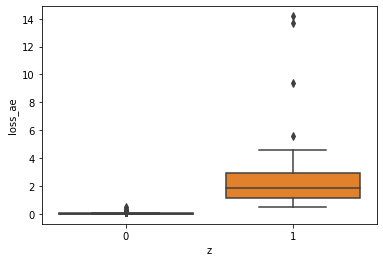

In [21]:
sns.boxplot(y = df2.loss_ae, x = df2.z)

### Conclusie

Auto-encoders zijn een geschikte manier om datapunten te herkennen die het dominante patroon in de data niet volgen. Er zijn wel twee voorwaardes waaraan voldaan moet worden: er is een dominant patroon in de data en de outliers zijn zodanig sterk in de minderheid dat ze het trainingsproces niet teveel beinvloeden.  

Als je dit notebook wil gebruiken, download dan ook de twee datasets en het plaatje van het netwerk. Succes!